# ML Final Project

# ASL Model

Data prep

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# input path
data_path ="C:\\Users\\acer\\Downloads\ASLIMAGE\\asl_alphabet_train\\asl_alphabet_train"

In [3]:
# image size
pic_size = 48

# number of batch
batch_size = 100

#labels
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "del", "nothing", "space"]

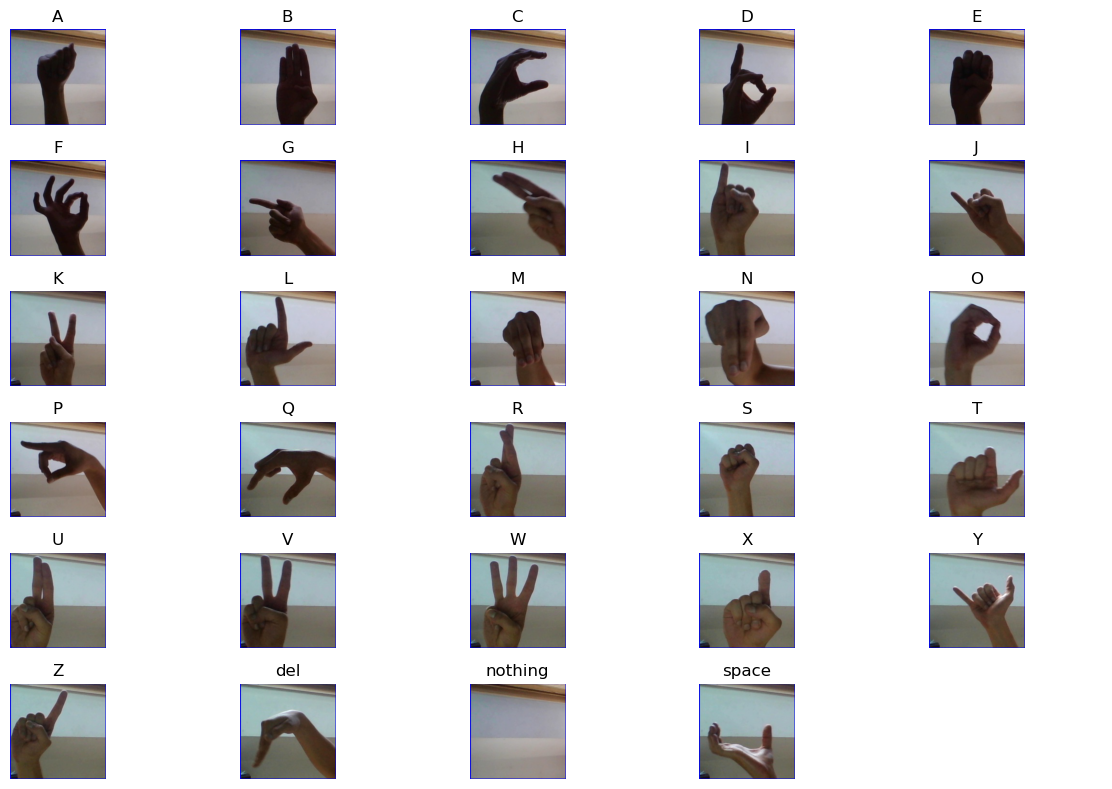

In [4]:
from PIL import Image

def display_images(data_path, labels):
    num_cols = 5  # Number of columns for subplots
    num_rows = (len(labels) + num_cols - 1) // num_cols  # Calculate number of rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Create subplots
    
    for i, label in enumerate(labels):
        # Find image path
        image_path = os.path.join(data_path, label, label + "1.jpg")
        
        # Load image
        image = Image.open(image_path)
        
        # Calculate subplot index
        row_index = i // num_cols
        col_index = i % num_cols
        
        # Display image
        axes[row_index, col_index].imshow(image)
        axes[row_index, col_index].set_title(label)
        axes[row_index, col_index].axis('off')
    
    # Hide any empty subplots
    for i in range(len(labels), num_rows * num_cols):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].axis('off')
    
    plt.tight_layout()
    plt.show()
    
display_images(data_path, labels)

In [4]:
# Creating df of our data
import glob

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(data_path, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

data = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

data

image_path  label
0      C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...      A
1      C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...      A
2      C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...      A
3      C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...      A
4      C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...      A
...                                                  ...    ...
86995  C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...  space
86996  C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...  space
86997  C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...  space
86998  C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...  space
86999  C:\Users\acer\Downloads\ASLIMAGE\asl_alphabet_...  space

[87000 rows x 2 columns]

In [6]:
import speech_recognition as sr

def listen_and_recognize():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        r.adjust_for_ambient_noise(source, duration=0.3)
        print("Speak now")
        audio = r.listen(source)
        
    return audio

def recognize_speech(audio):
    r = sr.Recognizer()
    try:
        text = r.recognize_google(audio)
        return text
    except sr.UnknownValueError:
        print("Sorry, I couldn't understand what you said.")
        return None
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")
        return None

def main():
    while True:
        audio = listen_and_recognize()
        text = recognize_speech(audio)
        
        if text:
            print("Speaker:", text)
            if text.lower() == 'quit':
                break
            else:
                # Saving the recognized text
                return text

if __name__ == "__main__":
    recognized_text = main()
    print("Recognized text:", recognized_text)

Speak now
Sorry, I couldn't understand what you said.
Speak now
Speaker: hello
Recognized text: hello


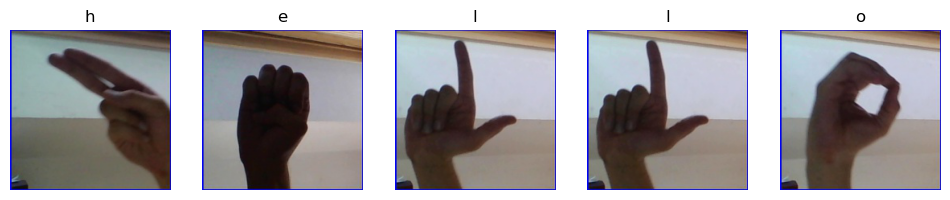

In [7]:
def word_to_sign_images(word, data):
    images = []
    labels = []
    for letter in word:
        # Get image path for the letter
        letter_data = data[data['label'] == letter.upper()]
        if not letter_data.empty:
            image_path = letter_data.iloc[0]['image_path']
            # Load image
            image = Image.open(image_path)
            images.append(image)
            labels.append(letter)  # Store the letter for later use
        else:
            print(f"No image found for letter '{letter}'")

    return images, labels

def display_sign_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(label)  # Set the title as the letter
    
    plt.show()

sign_images, labels = word_to_sign_images(recognized_text, data)
display_sign_images(sign_images, labels)

In [5]:
# Splitting Dataset to 70% training, testing and validation 15% each and shuffling it
X_train, X_test, y_train, y_test = train_test_split(
    data["image_path"], data["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=data["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [6]:
data_train.shape, data_val.shape, data_test.shape

((58103, 2), (15847, 2), (13050, 2))

In [7]:
data_train.shape, data_val.shape, data_test.shape

((58103, 2), (15847, 2), (13050, 2))

In [8]:
#data Augmentation
def data_augmentation():
    datagen = ImageDataGenerator(
        rescale=1/255., 
        rotation_range=20, 
        width_shift_range=0.2, 
        height_shift_range=0.2,
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True, 
        fill_mode='nearest'
    )    
    # Training df
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size= batch_size,
        target_size=(pic_size, pic_size),
    )

    # Validation df
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=batch_size,
        target_size=(pic_size, pic_size),
    )
    
    # Testing df
        # Data augmentation for testing (without augmentation)
    test_datagen = ImageDataGenerator(rescale=1/255.)
    
    test_generator = test_datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(pic_size, pic_size),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [9]:
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


Model Build

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Loading pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(pic_size, pic_size, 3), include_top=False, weights='imagenet')

# Unfreezing some layers in the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  
output = Dense(len(labels), activation='softmax')(x)

# The fine-tuned model
model = Model(inputs=base_model.input, outputs=output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 24, 24, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 24, 24, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 24, 24, 32)           0         ['bn_Conv1[0][0]']        

In [12]:
# Learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * 0.1  # to reduce learning rate by *0.1 after 10 epochs

lr_scheduler = LearningRateScheduler(lr_schedule)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler])

Epoch 1/15
582/582 [==============================] - 3828s 7s/step - loss: 1.2798 - accuracy: 0.6269 - val_loss: 3.2220 - val_accuracy: 0.1239 - lr: 0.0010
Epoch 2/15
582/582 [==============================] - 3288s 6s/step - loss: 0.5938 - accuracy: 0.8244 - val_loss: 3.7389 - val_accuracy: 0.0596 - lr: 0.0010
Epoch 3/15
582/582 [==============================] - 3529s 6s/step - loss: 0.5088 - accuracy: 0.8484 - val_loss: 3.7218 - val_accuracy: 0.1166 - lr: 0.0010
Epoch 4/15
582/582 [==============================] - 2951s 5s/step - loss: 0.5886 - accuracy: 0.8243 - val_loss: 6.8084 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 5/15
582/582 [==============================] - 3441s 6s/step - loss: 0.4862 - accuracy: 0.8564 - val_loss: 5.2690 - val_accuracy: 0.3336 - lr: 0.0010
Epoch 6/15
582/582 [==============================] - 3081s 5s/step - loss: 0.5199 - accuracy: 0.8447 - val_loss: 5.3053 - val_accuracy: 0.1497 - lr: 0.0010
Epoch 7/15
582/582 [==============================] - 1088

In [14]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 422s 32ms/step - loss: 0.0772 - accuracy: 0.9738
Test Accuracy: 97.38%


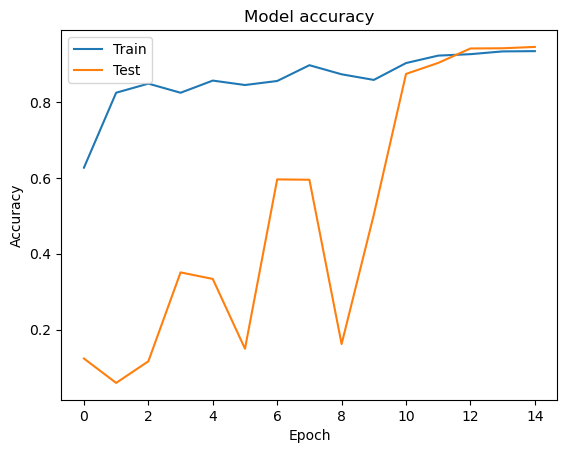

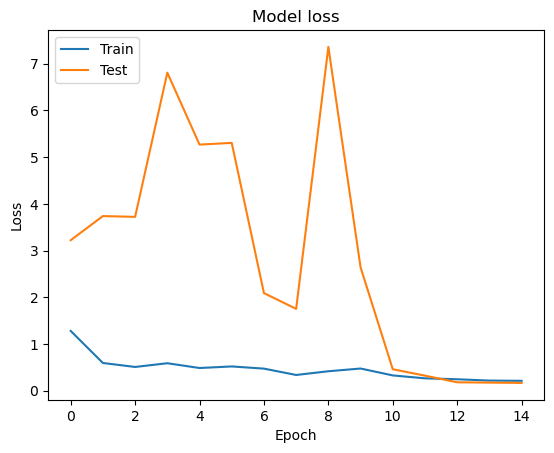

In [15]:
# Plot of training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot of training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
model.save("C:\\Users\\acer\\Documents\\USJ\\Master Data Science\\Sem 2\\Machine Learning and Deep Learning\\mobile_net_model")

INFO:tensorflow:Assets written to: C:\Users\acer\Documents\USJ\Master Data Science\Sem 2\Machine Learning and Deep Learning\mobile_net_model\assets


INFO:tensorflow:Assets written to: C:\Users\acer\Documents\USJ\Master Data Science\Sem 2\Machine Learning and Deep Learning\mobile_net_model\assets


In [17]:
from sklearn.metrics import classification_report

# classification report
y_pred = model.predict(test_generator)
predicted_classes = np.argmax(y_pred, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

13050/13050 [==============================] - 125s 9ms/step
Classification Report:
               precision    recall  f1-score   support

           A       0.99      0.91      0.95       450
           B       0.99      0.99      0.99       450
           C       1.00      1.00      1.00       450
           D       1.00      0.99      0.99       450
           E       0.98      0.99      0.98       450
           F       1.00      0.99      0.99       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      0.98      0.99       450
           J       1.00      1.00      1.00       450
           K       0.98      0.91      0.94       450
           L       1.00      1.00      1.00       450
           M       0.97      0.82      0.89       450
           N       0.89      0.99      0.94       450
           O       1.00      0.99      1.00       450
           P       1.00      1.00      1.00       

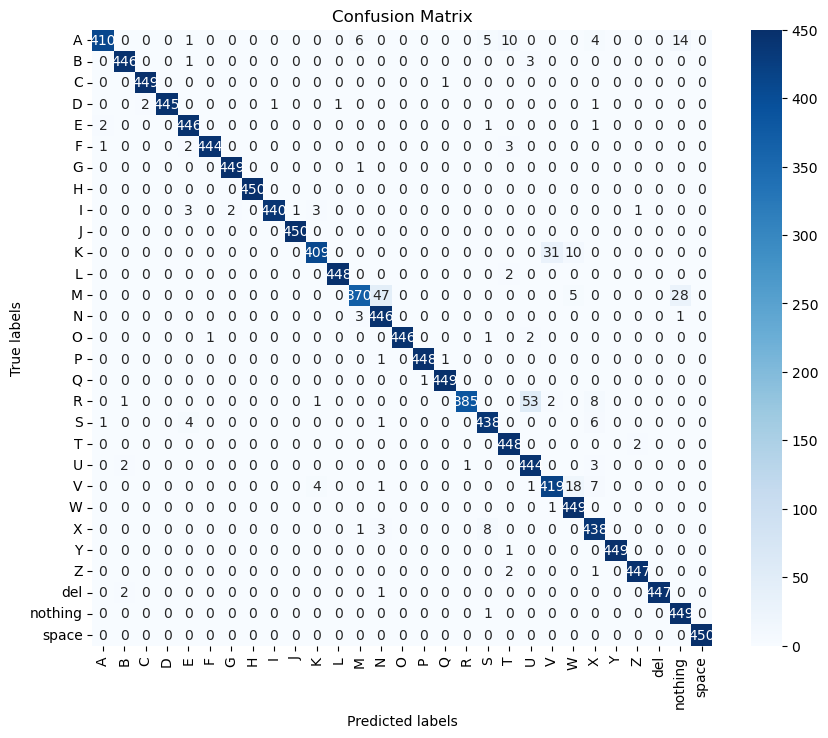

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 3s 3s/step


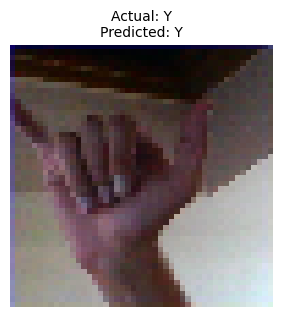

In [19]:
#Making random predictions
batch_size = test_generator.batch_size

sample_size = min(10, batch_size)

sample_images, sample_labels = next(test_generator)
sample_predictions = model.predict(sample_images)
sample_predicted_labels = np.argmax(sample_predictions, axis=1)

#displaying images with their actual and predicted labels
plt.figure(figsize=(15, 6))
for i in range(sample_size):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    actual_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[sample_predicted_labels[i]]
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Arabic Sign Language Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
path = "C:\\Users\\acer\\Downloads\\arabic signs\\RGB ArSL dataset"

In [3]:
classes = np.sort(os.listdir(path))
arabic_letters_unicode = ['ع', 'ال', 'أ', 'ب', 'ض', 'د', 'ف', 'غ', 'هـ', 'ه', 'ج', 'ك'
                          , 'خ', 'لأ', 'ل', 'م', 'ن', 'ق', 'ر', 'ص', 'س', 'ش'
                          , 'ت', 'ط', 'ة', 'ذ', 'ظ', 'ث', 'و', 'ي', 'ز', 'زاي']

arabic_to_class = dict(zip(arabic_letters_unicode, classes))

In [4]:
classes

array(['Ain', 'Al', 'Alef', 'Beh', 'Dad', 'Dal', 'Feh', 'Ghain', 'Hah',
       'Heh', 'Jeem', 'Kaf', 'Khah', 'Laa', 'Lam', 'Meem', 'Noon', 'Qaf',
       'Reh', 'Sad', 'Seen', 'Sheen', 'Tah', 'Teh', 'Teh_Marbuta', 'Thal',
       'Theh', 'Waw', 'Yeh', 'Zah', 'Zain'], dtype='<U11')

In [5]:
arabic_to_class

{'ع': 'Ain',
 'ال': 'Al',
 'أ': 'Alef',
 'ب': 'Beh',
 'ض': 'Dad',
 'د': 'Dal',
 'ف': 'Feh',
 'غ': 'Ghain',
 'هـ': 'Hah',
 'ه': 'Heh',
 'ج': 'Jeem',
 'ك': 'Kaf',
 'خ': 'Khah',
 'لأ': 'Laa',
 'ل': 'Lam',
 'م': 'Meem',
 'ن': 'Noon',
 'ق': 'Qaf',
 'ر': 'Reh',
 'ص': 'Sad',
 'س': 'Seen',
 'ش': 'Sheen',
 'ت': 'Tah',
 'ط': 'Teh',
 'ة': 'Teh_Marbuta',
 'ذ': 'Thal',
 'ظ': 'Theh',
 'ث': 'Waw',
 'و': 'Yeh',
 'ي': 'Zah',
 'ز': 'Zain'}

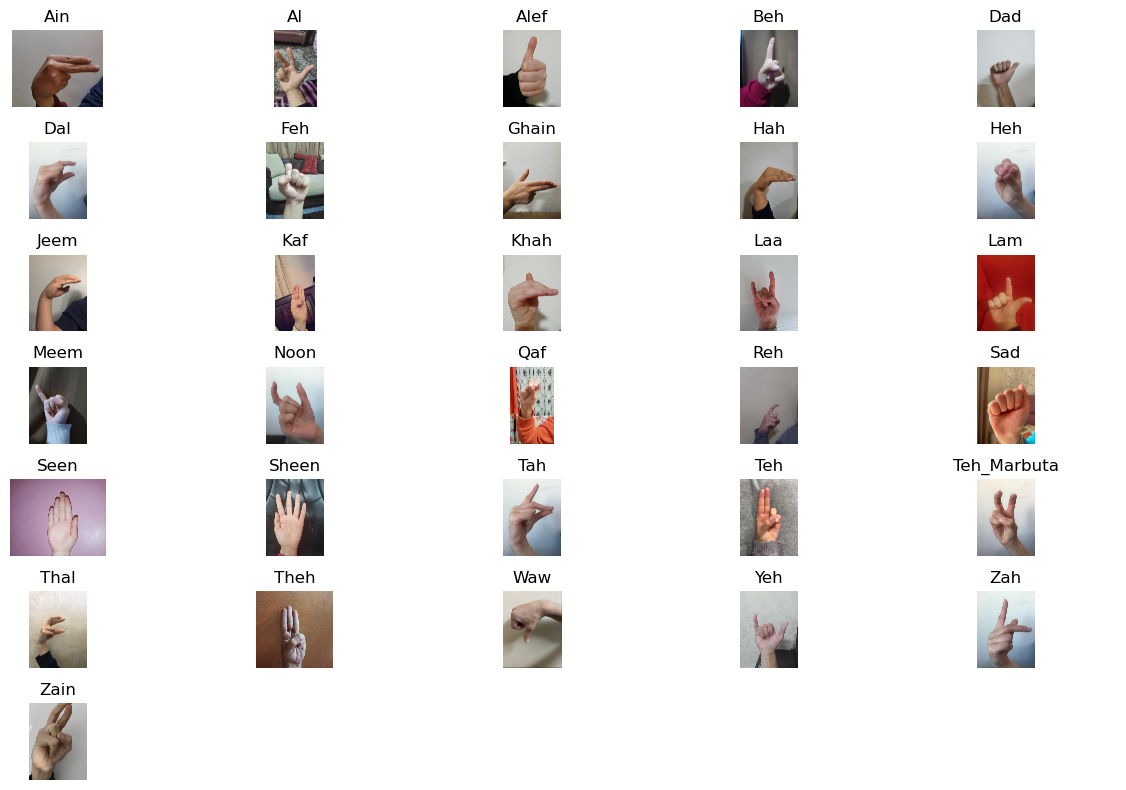

In [6]:
from PIL import Image

def display_arabic_images(data_path, classes):
    num_cols = 5  # Number of columns for subplots
    num_rows = (len(classes) + num_cols - 1) // num_cols  # Calculate number of rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Create subplots
    
    for i, class_name in enumerate(classes):
        # Find image path
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)
        if image_files:
            image_file = image_files[0]  # Take the first image
            image_path = os.path.join(class_path, image_file)
        
            # Load image
            try:
                image = Image.open(image_path)
                # Calculate subplot index
                row_index = i // num_cols
                col_index = i % num_cols

                # Display image
                axes[row_index, col_index].imshow(image)
                axes[row_index, col_index].set_title(class_name)
                axes[row_index, col_index].axis('off')
            except FileNotFoundError:
                print(f"File not found: {image_path}")
    
    for i in range(len(classes), num_rows * num_cols):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].axis('off')
    
    plt.tight_layout()
    plt.show()
    
display_arabic_images(path,classes)

In [7]:
import glob

list_path = []
list_labels = []

# Iterate over each class
for class_name in classes:
    class_path = os.path.join(path, class_name, "*.jpg")  
    image_files = glob.glob(class_path)
    
    list_path.extend(image_files)
    list_labels.extend([class_name] * len(image_files))

# Create DataFrame
df = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

df

image_path label
0     C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Ain
1     C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Ain
2     C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Ain
3     C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Ain
4     C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Ain
...                                                 ...   ...
6619  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...  Zain
6620  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...  Zain
6621  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...  Zain
6622  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...  Zain
6623  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...  Zain

[6624 rows x 2 columns]

In [8]:
corrupted_path = "C:\\Users\\acer\\Downloads\\arabic signs\\RGB ArSL dataset\\Yeh\\Yeh_61.jpg"
df = df[df['image_path'] != corrupted_path]

In [19]:
# Check for NaN values in the entire DataFrame
nan_df = data_train.isna()

# Count the number of NaN values in each column
nan_counts_per_column = nan_df.sum()

# Count the number of NaN values in each row
nan_counts_per_row = nan_df.sum(axis=1)

# Total number of NaN values in the DataFrame
total_nan_count = nan_df.sum().sum()

# Print the results
print("NaN counts per column:")
print(nan_counts_per_column)
print("\nNaN counts per row:")
print(nan_counts_per_row)
print("\nTotal number of NaN values in the DataFrame:", total_nan_count)

NaN counts per column:
image_path    0
label         0
dtype: int64

NaN counts per row:
4113    0
3591    0
518     0
1950    0
4499    0
       ..
3547    0
35      0
1773    0
2911    0
6368    0
Length: 4422, dtype: int64

Total number of NaN values in the DataFrame: 0


In [10]:
# Splitting Dataset to 70% training, testing and validation 15% each and shuffling it
X_train, X_test, y_train, y_test = train_test_split(
    df["image_path"], df["label"], 
    test_size=0.15, 
    random_state=42, 
    shuffle=True, 
    stratify=df["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=42,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [11]:
data_train.shape, data_val.shape, data_test.shape

((4422, 2), (1207, 2), (994, 2))

In [12]:
data_train

image_path  label
4113  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...    Sad
3591  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Noon
518   C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Alef
1950  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...    Hah
4499  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...  Sheen
...                                                 ...    ...
3547  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...   Noon
35    C:\Users\acer\Downloads\arabic signs\RGB ArSL ...    Ain
1773  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...  Ghain
2911  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...    Laa
6368  C:\Users\acer\Downloads\arabic signs\RGB ArSL ...    Zah

[4422 rows x 2 columns]

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image size
pic_size = 256

# number of batch
batch_size = 32

# No data Augmentation with RGB images
def data_no_augmentation_rgb():
    # For training data (without augmentation)
    train_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=batch_size,
        target_size=(pic_size, pic_size),
    )

    # For validation data (without augmentation)
    validation_datagen = ImageDataGenerator()
    
    validation_generator = validation_datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=batch_size,
        target_size=(pic_size, pic_size),
    )
    
    # For testing data (without augmentation)
    test_datagen = ImageDataGenerator()
    
    test_generator = test_datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(pic_size, pic_size),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [40]:
train_generator, validation_generator, test_generator = data_augmentation()

Found 4422 validated image filenames belonging to 31 classes.
Found 1207 validated image filenames belonging to 31 classes.
Found 994 validated image filenames belonging to 31 classes.


In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

num_classes = 31
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model layers
base_model.trainable = False

# custom classification layers 
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  
x = Dense(num_classes, activation='softmax')(x)

arabic_model = Model(inputs=base_model.input, outputs=x)

In [52]:
arabic_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

In [53]:
arabic_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Train the model
history = arabic_model.fit(
    train_generator,
    epochs=100,
    batch_size= 50,
    validation_data=validation_generator
)

Epoch 1/100
139/139 [==============================] - 1343s 10s/step - loss: 3.4499 - accuracy: 0.0715 - val_loss: 3.0475 - val_accuracy: 0.2196
Epoch 2/100
139/139 [==============================] - 1237s 9s/step - loss: 2.9558 - accuracy: 0.1825 - val_loss: 2.6841 - val_accuracy: 0.3016
Epoch 3/100
139/139 [==============================] - 1217s 9s/step - loss: 2.6210 - accuracy: 0.2644 - val_loss: 2.3631 - val_accuracy: 0.3637
Epoch 4/100
139/139 [==============================] - 1248s 9s/step - loss: 2.3475 - accuracy: 0.3256 - val_loss: 2.1141 - val_accuracy: 0.4292
Epoch 5/100
139/139 [==============================] - 1233s 9s/step - loss: 2.1500 - accuracy: 0.3826 - val_loss: 1.9914 - val_accuracy: 0.4466
Epoch 6/100
139/139 [==============================] - 1189s 9s/step - loss: 1.9869 - accuracy: 0.4111 - val_loss: 1.8852 - val_accuracy: 0.4598
Epoch 7/100
139/139 [==============================] - 1227s 9s/step - loss: 1.8762 - accuracy: 0.4367 - val_loss: 1.7826 - val_a

In [ ]:
scores = arabic_model.evaluate(test_generator)
print("%s: %.2f%%" % ("Test Accuracy", scores[1]*100))

In [ ]:
# Plot of training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Arabic Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot of training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Arabic Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
arabic_model.save("C:\\Users\\acer\\Documents\\USJ\\Master Data Science\\Sem 2\\Machine Learning and Deep Learning\\arabic_model")

In [ ]:
from sklearn.metrics import classification_report

# classification report
y_pred = arabic_model.predict(test_generator)
predicted_classes = np.argmax(y_pred, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Making random predictions
batch_size = test_generator.batch_size

sample_size = min(10, batch_size)

sample_images, sample_labels = next(test_generator)
sample_predictions = model.predict(sample_images)
sample_predicted_labels = np.argmax(sample_predictions, axis=1)

#displaying images with their actual and predicted labels
plt.figure(figsize=(15, 6))
for i in range(sample_size):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    actual_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[sample_predicted_labels[i]]
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# English to Arabic Translation Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,LSTM,TimeDistributed,RepeatVector,GRU,Embedding
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_csv("C:\\Users\\acer\\Downloads\\translation\\ara_eng.txt", delimiter="\t", names=["english", "arabic"])
data.head()

english   arabic
0     Hi.  مرحبًا.
1    Run!    اركض!
2   Help!  النجدة!
3   Jump!    اقفز!
4   Stop!      قف!

In [3]:
data

english  \
0                                                    Hi.   
1                                                   Run!   
2                                                  Help!   
3                                                  Jump!   
4                                                  Stop!   
...                                                  ...   
24633  rising voices promoting a more linguistically ...   
24634  following last year s successful campaign we i...   
24635  during last year s challenge we also met langu...   
24636  to take part just follow the simple steps outl...   
24637  you will also find links to some free web base...   

                                                  arabic  
0                                                مرحبًا.  
1                                                  اركض!  
2                                                النجدة!  
3                                                  اقفز!  
4                                                    قف!  
...                                                  ...  
24633  شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...  
24634  استكمالا لنجاح حملة العام السابق ندعوكم للمشار...  
24635  تعرفنا خلال تحدي العام الماضي على ابطال لغويين...  
24636  للمشاركة في التحدي اتبع الخطوات الموضحة على ال...  
24637  ستجد ايضا روابط لمجموعة من منصات ابداع الميم ا...  

[24638 rows x 2 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24638 entries, 0 to 24637
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  24638 non-null  object
 1   arabic   24638 non-null  object
dtypes: object(2)
memory usage: 385.1+ KB


In [5]:
data.duplicated().sum()

231

In [6]:
data = data.drop_duplicates()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24407 entries, 0 to 24637
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  24407 non-null  object
 1   arabic   24407 non-null  object
dtypes: object(2)
memory usage: 572.0+ KB


In [8]:
import plotly.subplots as sp
import plotly.graph_objects as go

input_lengths = [len(seq.split()) for seq in data['english']]
output_lengths = [len(seq.split()) for seq in data['arabic']]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('English Sentence Lengths', 'Arabic Sentence Lengths'))

hist_input = go.Histogram(x=input_lengths, nbinsx=50, name='English')
hist_output = go.Histogram(x=output_lengths, nbinsx=50, name='Arabic')

fig.add_trace(hist_input, row=1, col=1)
fig.add_trace(hist_output, row=1, col=2)

fig.update_layout(showlegend=False, title_text='Distribution of Sentence Lengths')
fig.update_xaxes(title_text='Sentence Length', row=1, col=1)
fig.update_xaxes(title_text='Sentence Length', row=1, col=2)

fig.show()

In [10]:
from collections import Counter

# Function to remove punctuation from a sentence
def remove_punctuation(sentence):
    translator = str.maketrans("", "", string.punctuation)
    return sentence.translate(translator)

# Combine all English sentences into a single string and remove punctuation
all_english_sentences = ' '.join(data['english'])
# all_english_sentences = remove_punctuation(all_english_sentences)

# Combine all Arabic sentences into a single string and remove punctuation
all_arabic_sentences = ' '.join(data['arabic'])
# all_arabic_sentences = remove_punctuation(all_arabic_sentences)

# Count word frequencies in English sentences
english_word_counts = Counter(all_english_sentences.lower().split())

# Count word frequencies in Arabic sentences
arabic_word_counts = Counter(all_arabic_sentences.split())

target_freq = 1

# Display the number of eng words that occur only once
print(f"English Words with Frequency equals {target_freq}:")
total = 0
for word, count in english_word_counts.items():
    if count == target_freq:
        total += 1
print(total)

# Display the number of arabic words that occur only once
print(f"Arabic Words with Frequency equals {target_freq}:")
total = 0
for word, count in arabic_word_counts.items():
    if count == target_freq:
        total += 1
print(total)

English Words with Frequency equals 1:
15281
Arabic Words with Frequency equals 1:
34129


In [32]:
import re

# preprocessing function
def preprocess_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply preprocessing to English and Arabic columns
data['english'] = data['english'].apply(preprocess_text)
data['arabic'] = data['arabic'].apply(preprocess_text)

data

C:\Users\acer\AppData\Local\Temp\ipykernel_12344\2668654020.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\acer\AppData\Local\Temp\ipykernel_12344\2668654020.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



english  \
0                                                     Hi   
1                                                    Run   
2                                                   Help   
3                                                   Jump   
4                                                   Stop   
...                                                  ...   
24633  rising voices promoting a more linguistically ...   
24634  following last year s successful campaign we i...   
24635  during last year s challenge we also met langu...   
24636  to take part just follow the simple steps outl...   
24637  you will also find links to some free web base...   

                                                  arabic  
0                                                  مرحبا  
1                                                   اركض  
2                                                 النجدة  
3                                                   اقفز  
4                                                     قف  
...                                                  ...  
24633  شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...  
24634  استكمالا لنجاح حملة العام السابق ندعوكم للمشار...  
24635  تعرفنا خلال تحدي العام الماضي على ابطال لغويين...  
24636  للمشاركة في التحدي اتبع الخطوات الموضحة على ال...  
24637  ستجد ايضا روابط لمجموعة من منصات ابداع الميم ا...  

[24407 rows x 2 columns]

In [33]:
# english tokenizer
english_tokenizer=Tokenizer()
english_tokenizer.fit_on_texts(data["english"])

vocab_size_english=len(english_tokenizer.word_index)
english_word_2_idx=english_tokenizer.word_index
english_idx_2_word={idx:word for word,idx in english_word_2_idx.items()}

In [34]:
vocab_size_english

26053

In [35]:
print(english_idx_2_word)

{1: 'the', 2: 'of', 3: 'to', 4: 'in', 5: 'and', 6: 'a', 7: 'is', 8: 'on', 9: 'i', 10: 'for', 11: 'that', 12: 'you', 13: 's', 14: 'by', 15: 'global', 16: 'voices', 17: 'with', 18: 'this', 19: 'it', 20: 'from', 21: 'are', 22: 'was', 23: 'as', 24: 'have', 25: 'he', 26: 'we', 27: 'has', 28: 'an', 29: 'be', 30: 'at', 31: 'not', 32: 'about', 33: 'their', 34: 'his', 35: 'who', 36: 'my', 37: 'do', 38: 'will', 39: 'what', 40: 'they', 41: 'can', 42: 'people', 43: 'but', 44: 'one', 45: 'or', 46: 'tom', 47: 'all', 48: 'me', 49: 'your', 50: 'she', 51: 'been', 52: 'more', 53: 'her', 54: 'how', 55: 'which', 56: 'there', 57: 'its', 58: 'like', 59: 'were', 60: 'also', 61: 'new', 62: 'media', 63: 'world', 64: 'us', 65: 'here', 66: 't', 67: 'our', 68: 'many', 69: 'up', 70: 'when', 71: 'some', 72: 'photo', 73: 'video', 74: 'if', 75: 'no', 76: 'out', 77: 'other', 78: 'country', 79: 'blogger', 80: 'blog', 81: 'time', 82: 'so', 83: 'internet', 84: 'after', 85: 'rights', 86: 'now', 87: 'where', 88: 'governmen

In [36]:
# arabic tokenizer
arabic_tokenizer=Tokenizer()
arabic_tokenizer.fit_on_texts(data["arabic"])
vocab_size_arabic=len(arabic_tokenizer.word_index)+1

arabic_word_2_idx=arabic_tokenizer.word_index
arabic_idx_2_word={idx:word for word,idx in arabic_word_2_idx.items()}

In [37]:
vocab_size_arabic

54770

In [38]:
print(arabic_word_2_idx)

{'في': 1, 'من': 2, 'على': 3, 'ان': 4, 'عن': 5, 'العالمية': 6, 'الاصوات': 7, 'الى': 8, 'لا': 9, 'هذا': 10, 'ما': 11, 'التي': 12, 'هذه': 13, 'مع': 14, 'الذي': 15, 'ذلك': 16, 'أن': 17, 'لم': 18, 'الانترنت': 19, 'او': 20, 'كان': 21, 'توم': 22, 'و': 23, 'هل': 24, 'كل': 25, 'بعد': 26, 'هو': 27, 'قبل': 28, 'حول': 29, 'تم': 30, 'موقع': 31, 'عام': 32, 'العالم': 33, 'حيث': 34, 'كما': 35, 'هناك': 36, 'المدون': 37, 'هنا': 38, 'اكثر': 39, 'بين': 40, 'خلال': 41, 'بعض': 42, 'قد': 43, 'كانت': 44, 'ايضا': 45, 'أنا': 46, 'إلى': 47, 'غير': 48, 'اي': 49, 'هي': 50, 'يوم': 51, 'مدونة': 52, 'انه': 53, 'الصورة': 54, 'حتى': 55, 'عبر': 56, 'اليوم': 57, 'الذين': 58, 'تويتر': 59, 'اخرى': 60, 'الان': 61, 'ليس': 62, 'انكليزي': 63, 'منذ': 64, 'تحت': 65, 'فيسبوك': 66, 'المتحدة': 67, 'كيف': 68, 'العديد': 69, 'ولكن': 70, 'الاعلام': 71, 'الناس': 72, 'مثل': 73, 'يمكن': 74, 'ضد': 75, 'عندما': 76, 'الانسان': 77, 'مصر': 78, 'لقد': 79, 'ايران': 80, 'تلك': 81, 'حقوق': 82, 'فقط': 83, 'صورة': 84, 'العام': 85, 'الحكومة': 86, 'لك

In [39]:
arabic_idx_2_word[1547]

'السباحة'

In [40]:
english_idx_2_word[125]

'very'

In [41]:
# Pad sequences transforming words to theor respective integers numbers(tokens)

token_eng=english_tokenizer.texts_to_sequences(data["english"])
token_ara=arabic_tokenizer.texts_to_sequences(data["arabic"])

padded_eng=pad_sequences(token_eng,maxlen=50,padding="post")
padded_ara=pad_sequences(token_ara,maxlen=50,padding="post")

In [42]:
padded_eng.shape, padded_ara.shape

((24407, 50), (24407, 50))

In [43]:
padded_eng[35]

array([139,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [44]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(padded_eng,padded_ara,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((19525, 50), (4882, 50), (19525, 50), (4882, 50))

In [45]:
model=Sequential()

model.add(Embedding(vocab_size_english, 50, input_length=50))
model.add(tf.keras.layers.Bidirectional(LSTM(units=128)))
model.add(tf.keras.layers.RepeatVector(50))
model.add(LSTM(128,return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size_arabic,activation="softmax")))

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            1302650   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              183296    
 nal)                                                            
                                                                 
 repeat_vector_2 (RepeatVect  (None, 50, 256)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 50, 128)           197120    
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 54770)        7065330   
 tributed)                                                       
                                                      

In [47]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Enable TensorFlow memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Train the model with reduced batch size
history = model.fit(X_train, y_train, batch_size=128, validation_split=0.2, verbose=2, epochs=50)

Epoch 1/50


KeyboardInterrupt: 

# Real time Detection

In [1]:
import tensorflow as tf
import cv2
import mediapipe as mp
import numpy as np
import time
import pandas as pd

In [2]:
model = tf.keras.models.load_model("C:\\Users\\acer\\Documents\\USJ\\Master Data Science\\Sem 2\\Machine Learning and Deep Learning\\mobile_net_model")

In [4]:
# Initializing Mediapipe Hands
mphands = mp.solutions.hands
hands = mphands.Hands()
mp_drawing = mp.solutions.drawing_utils

# Opening
cap = cv2.VideoCapture(0)

# Checking webcam opened
if not cap.isOpened():
    print("Error: Failed to open webcam.")
    exit()

_, frame = cap.read()
h, w, c = frame.shape

img_counter = 0

letterpred = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "del", "nothing", "space"]
pred = ""

while True:
    # Reading frame from webcam
    ret, frame = cap.read()
    
    # Checking frame is read
    if not ret:
        print("Error: Failed to capture frame.")
        break

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC to close
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE to predict and print predictions
        analysisframe = frame
        showframe = analysisframe
        cv2.imshow("Frame", showframe)
        
        framergbanalysis = cv2.cvtColor(analysisframe, cv2.COLOR_BGR2RGB)
        resultanalysis = hands.process(framergbanalysis)
        hand_landmarksanalysis = resultanalysis.multi_hand_landmarks
        if hand_landmarksanalysis:
            for handLMsanalysis in hand_landmarksanalysis:
                #dimensions of the bounding box to be arounf the hand
                x_max = 0
                y_max = 0
                x_min = w
                y_min = h
                for lmanalysis in handLMsanalysis.landmark:
                    x, y = int(lmanalysis.x * w), int(lmanalysis.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y
                # Adding some padding to the bounding box
                y_min -= 20
                y_max += 20
                x_min -= 20
                x_max += 20 

        # Crop resize and converting to grayscale
        analysisframe = cv2.cvtColor(analysisframe, cv2.COLOR_BGR2GRAY)
        analysisframe = analysisframe[y_min:y_max, x_min:x_max]
        analysisframe = cv2.resize(analysisframe,(48,48))
        analysisframe = cv2.cvtColor(analysisframe, cv2.COLOR_GRAY2BGR)

        print("Analysis Frame Shape:", analysisframe.shape)

        colname = [f"pixel_{i}" for i in range(48*48*3)]

        nlist = analysisframe.flatten().tolist()
        
        datan = pd.DataFrame([nlist], columns=colname)

        # Normalizing pixel values
        pixeldata = datan.values
        pixeldata = pixeldata / 255
        pixeldata = pixeldata.reshape(-1,48,48,3)

        # Predicting gesture using a pre-trained model
        prediction = model.predict(pixeldata)
        predarray = np.array(prediction[0])
        letter_prediction_dict = {letterpred[i]: predarray[i] for i in range(len(letterpred))}
        predarrayordered = sorted(predarray, reverse=True)
        predicted_character = None

        # Finding the predicted character with the highest confidence
        for key, value in letter_prediction_dict.items():
            if value == predarrayordered[0]:
                predicted_character = key
                # Print predicted character and confidence
                print("Predicted Character : ", predicted_character)
                print('Confidence : ', 100*value)
                # Display prediction on frame
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = f"Predicted Character: {predicted_character} (Confidence: {100*value:.2f}%)"
                cv2.putText(frame, text, (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
                break  # Exit loop after finding the highest confidence prediction

        # Handling special cases for prediction
        if predicted_character == "nothing":
            pred = pred
        elif predicted_character == "space":
            pred += " "
        elif predicted_character == "del":
            pred = pred[:-1]
        else:
            pred += predicted_character

        # Delay for 5 seconds
        time.sleep(5)


    #continuously executed to detect hand gestures in real-time
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(framergb)
    hand_landmarks = result.multi_hand_landmarks
    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            for lm in handLMs.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y
            y_min -= 20
            y_max += 20
            x_min -= 20
            x_max += 20
            # Draw rectangle around hand region
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Display the frame
    cv2.imshow("Frame", frame)

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

Analysis Frame Shape: (48, 48, 3)
1/1 [==============================] - 0s 21ms/step
Predicted Character :  S
Confidence :  79.65537309646606
Escape hit, closing...


In [17]:
pred

'AD'

In [18]:
import pyttsx3

text_to_speech = pyttsx3.init()

voices = text_to_speech.getProperty('voices')
text_to_speech.setProperty('voice', voices[1].id) # 0 for male and 1 for female

# convert text to speech
text_to_speech.say(pred)

# save the audio file
text_to_speech.save_to_file(pred, 'test.mp3')

# listen to audio
text_to_speech.runAndWait()

Thank you!

In [49]:
# Using a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("translation_en_to_ar", model="marefa-nlp/marefa-mt-en-ar")

# Translate text
text = "Hello how are you doing today?"
output = pipe(text)

print(output)

Downloading:   0%|          | 0.00/801k [00:00<?, ?B/s]

C:\Users\acer\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\acer\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/917k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

C:\Users\acer\anaconda3\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'آلو كيف تبلي اليوم؟'}]


In [50]:
text = "Final project"
pipe(text)

[{'translation_text': 'المشروع النهائي'}]